In [1]:
import os
import json
import shutil
import random

# Ścieżki do folderów
train_folder = 'C:/Users/Kamil/PycharmProjects/transferLearning/GOPRO_NEW/images/train'
val_folder = 'C:/Users/Kamil/PycharmProjects/transferLearning/GOPRO_NEW/images/val'
train_mini_folder = 'C:/Users/Kamil/PycharmProjects/transferLearning/GOPRO_NEW/images/train_small'
val_mini_folder = 'C:/Users/Kamil/PycharmProjects/transferLearning/GOPRO_NEW/images/val_small'

# Tworzenie nowych folderów
os.makedirs(train_mini_folder, exist_ok=True)
os.makedirs(val_mini_folder, exist_ok=True)

# Funkcja do wybrania podzbioru obrazów i przeniesienia ich
def create_mini_dataset(img_folder, mini_folder, json_file, fraction):
    # Ładowanie pliku JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Wybór losowych obrazów
    images = data['images']
    selected_images = random.sample(images, max(1, int(len(images) * fraction)))

    # Tworzenie zbioru ID wybranych obrazów
    selected_ids = {img['id'] for img in selected_images}

    # Przenoszenie wybranych obrazów
    for img in selected_images:
        img_path = os.path.join(img_folder, img['file_name'])
        shutil.copy(img_path, mini_folder)

    # Tworzenie nowego pliku JSON
    new_data = {
        "info": data["info"],
        "licenses": data["licenses"],
        "images": [],
        "annotations": [],
        "categories": data["categories"]  # Zachowaj kategorie
    }

    # Dodawanie wybranych obrazów do nowego pliku JSON
    for img in selected_images:
        new_data["images"].append(img)
        
        # Dodawanie adnotacji tylko dla wybranych obrazów
        for annotation in data['annotations']:
            if annotation['image_id'] == img['id']:
                new_data["annotations"].append(annotation)

    # Upewnij się, że id adnotacji są unikalne
    for idx, annotation in enumerate(new_data["annotations"], start=1):
        annotation['id'] = idx

    # Zapis nowego pliku JSON
    new_json_file = json_file.replace('.json', '_small.json')
    with open(new_json_file, 'w') as f:
        json.dump(new_data, f, indent=4)

# Użycie funkcji do stworzenia mini zbiorów
create_mini_dataset(train_folder, train_mini_folder, 'C:/Users/Kamil/PycharmProjects/transferLearning/GOPRO_NEW/labels/train.json', 0.1)
create_mini_dataset(val_folder, val_mini_folder, 'C:/Users/Kamil/PycharmProjects/transferLearning/GOPRO_NEW/labels/val.json', 0.1)

In [1]:
from argparse import Namespace
args = Namespace(config='configs/rtdetrv2/rtdetrv2_r18vd_sp1_120e_coco.yml', resume=None, tuning=None, device='cuda', seed=0, use_amp=True, output_dir=None, summary_dir=None, test_only=False, update=None, print_method='builtin', print_rank=0, local_rank=None)

In [2]:
# COCO classes
# CLASSES = [
#     'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
#     'truck', 'truck', 'boat', 'fire hydrant', 'fire hydrant', 'N/A2',
#     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'cow',
#     'sheep', 'cow', 'zebra', 'giraffe', 'zebra', 'giraffe', 'N/A', 'backpack',
#     'umbrella', 'N/A3', 'N/A4', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
#     'skateboard', 'sports ball', 'kite', 'baseball bat', 'wine glass',
#     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'bowl', 'wine glass',
#     'cup', 'fork', 'orange', 'broccoli', 'bowl', 'banana', 'apple', 'sandwich',
#     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
#     'chair', 'couch', 'potted plant', 'bed', 'N/A6', 'dining table', 'N/A7',
#     'N/A8', 'toilet', 'N/A9', 'tv', 'laptop', 'clock', 'remote', 'keyboard',
#     'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A10',
#     'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
#     'toothbrush'
# ]
CLASSES = ['person']

#coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None, classes=CLASSES):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    #unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    #image = unimage
    image = img
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{classes[label.item()]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [4]:
import os
os.chdir(r"C:\Users/Kamil/PycharmProjects/people_detection_310/RT-DETR/rtdetrv2_pytorch")
current_directory = os.getcwd()
print(current_directory)

C:\Users\Kamil\PycharmProjects\people_detection_310\RT-DETR\rtdetrv2_pytorch


In [5]:
import os 
import sys 

import argparse

from src.misc import dist_utils
from src.core import YAMLConfig, yaml_utils
from src.solver import TASKS
dist_utils.setup_distributed(args.print_rank, args.print_method, seed=args.seed)

Not init distributed mode.


False

In [6]:
update_dict = yaml_utils.parse_cli(args.update)
update_dict.update({k: v for k, v in args.__dict__.items() \
    if k not in ['update', ] and v is not None})

cfg = YAMLConfig(args.config, **update_dict)
print('cfg: ', cfg.__dict__)

solver = TASKS[cfg.yaml_cfg['task']](cfg)

cfg:  {'task': 'detection', '_model': None, '_postprocessor': None, '_criterion': None, '_optimizer': None, '_lr_scheduler': None, '_lr_warmup_scheduler': None, '_train_dataloader': None, '_val_dataloader': None, '_ema': None, '_scaler': None, '_train_dataset': None, '_val_dataset': None, '_collate_fn': None, '_evaluator': None, '_writer': None, 'num_workers': 0, 'batch_size': None, '_train_batch_size': None, '_val_batch_size': None, '_train_shuffle': None, '_val_shuffle': None, 'resume': None, 'tuning': None, 'epoches': 120, 'last_epoch': -1, 'use_amp': True, 'use_ema': True, 'ema_decay': 0.9999, 'ema_warmups': 2000, 'sync_bn': True, 'clip_max_norm': 0.1, 'find_unused_parameters': False, 'seed': 0, 'print_freq': 100, 'checkpoint_freq': 1, 'output_dir': './output/rtdetrv2_r18vd_sp1_120e_coco', 'summary_dir': None, 'device': 'cuda', 'yaml_cfg': {'task': 'detection', 'num_classes': 1, 'remap_mscoco_category': True, 'train_dataloader': {'type': 'DataLoader', 'dataset': {'type': 'CocoDetec

In [7]:
solver.train()

Load PResNet18 state_dict
Initial lr: [0.0001, 0.0001]
Current configuration for dataloader: {'type': 'DataLoader', 'dataset': {'type': 'CocoDetection', 'img_folder': 'C:\\Users\\Kamil\\PycharmProjects\\transferLearning\\GOPRO_NEW\\images\\train_mini', 'ann_file': 'C:\\Users\\Kamil\\PycharmProjects\\transferLearning\\GOPRO_NEW\\labels\\train_mini.json', 'transforms': {'type': 'Compose', 'ops': [{'type': 'RandomPhotometricDistort', 'p': 0.5}, {'type': 'RandomZoomOut', 'fill': 0}, {'type': 'RandomIoUCrop', 'p': 0.8}, {'type': 'SanitizeBoundingBoxes', 'min_size': 1}, {'type': 'RandomHorizontalFlip'}, {'type': 'Resize', 'size': [640, 640]}, {'type': 'SanitizeBoundingBoxes', 'min_size': 1}, {'type': 'ConvertPILImage', 'dtype': 'float32', 'scale': True}, {'type': 'ConvertBoxes', 'fmt': 'cxcywh', 'normalize': True}], 'policy': {'name': 'stop_epoch', 'epoch': 117, 'ops': ['RandomPhotometricDistort', 'RandomZoomOut', 'RandomIoUCrop']}}}, 'shuffle': True, 'batch_size': 16, 'num_workers': 4, 'dro

In [8]:


solver.train_dataloader.dataset

Dataset CocoDetection
    Number of datapoints: 208
    Root location: C:\Users\Kamil\PycharmProjects\transferLearning\GOPRO_NEW\images\train_mini
     img_folder: C:\Users\Kamil\PycharmProjects\transferLearning\GOPRO_NEW\images\train_mini
     ann_file: C:\Users\Kamil\PycharmProjects\transferLearning\GOPRO_NEW\labels\train_mini.json
     return_masks: False
     transforms:
       Compose(
          RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=0.5)
          RandomZoomOut(p=0.5, fill=0, side_range=(1.0, 4.0))
          RandomIoUCrop(min_scale=0.3, max_scale=1, min_aspect_ratio=0.5, max_aspect_ratio=2, options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], trials=40, p=0.8)
          SanitizeBoundingBoxes(min_size=1, labels_getter=default)
          RandomHorizontalFlip(p=0.5)
          Resize(size=[640, 640], interpolation=InterpolationMode.BILINEAR, antialias=True)
          SanitizeBoundingBoxes(min_size=1, labels_getter=

In [99]:
CLASSES

['person']

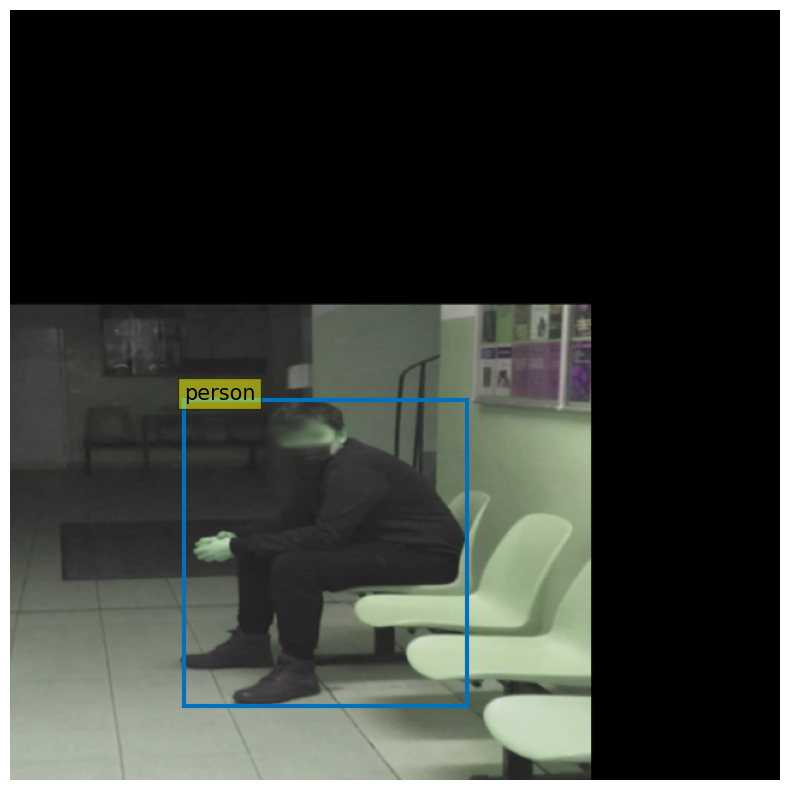

In [12]:
sample = solver.train_dataloader.dataset[10]
plot_results(sample[0], sample[1]["labels"], sample[1]["boxes"], classes=CLASSES)

In [13]:
for batch in solver.train_dataloader:
    break
batch

(tensor([[[[0.6431, 0.6431, 0.6431,  ..., 0.6078, 0.6157, 0.6157],
           [0.6431, 0.6431, 0.6431,  ..., 0.6078, 0.6157, 0.6157],
           [0.6431, 0.6431, 0.6431,  ..., 0.6078, 0.6157, 0.6157],
           ...,
           [0.5647, 0.5647, 0.5686,  ..., 0.3137, 0.3176, 0.3176],
           [0.5647, 0.5647, 0.5686,  ..., 0.3137, 0.3176, 0.3176],
           [0.5647, 0.5647, 0.5686,  ..., 0.3137, 0.3176, 0.3176]],
 
          [[0.7216, 0.7216, 0.7216,  ..., 0.6980, 0.6941, 0.6941],
           [0.7216, 0.7216, 0.7216,  ..., 0.6980, 0.6941, 0.6941],
           [0.7216, 0.7216, 0.7216,  ..., 0.6980, 0.6941, 0.6941],
           ...,
           [0.6588, 0.6588, 0.6588,  ..., 0.3843, 0.3843, 0.3843],
           [0.6588, 0.6588, 0.6588,  ..., 0.3843, 0.3843, 0.3843],
           [0.6588, 0.6588, 0.6588,  ..., 0.3843, 0.3843, 0.3843]],
 
          [[0.5961, 0.5961, 0.6000,  ..., 0.5725, 0.5686, 0.5686],
           [0.5961, 0.5961, 0.6000,  ..., 0.5725, 0.5686, 0.5686],
           [0.5961, 0.59

In [14]:
batch[0].shape

torch.Size([16, 3, 640, 640])

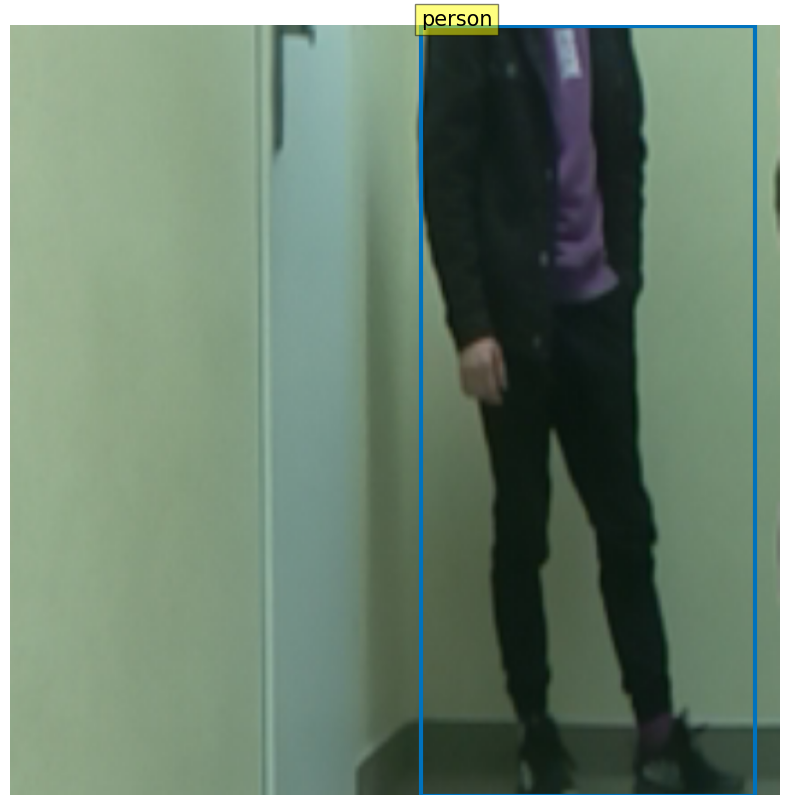

In [15]:
batch_idx = 0
plot_results(batch[0][batch_idx], batch[1][batch_idx]["labels"], batch[1][batch_idx]["boxes"], classes=CLASSES)



In [16]:
solver.criterion

RTDETRCriterionv2(
  (matcher): HungarianMatcher()
)

In [17]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")


CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [18]:
device = "cuda:0"
sample = batch[0].to(device)
def dic_to_device(dic, device):
    return {k: v.to(device) for k, v in dic.items()}
targets = [dic_to_device(dic, device) for dic in batch[1]]

In [19]:
preds = solver.model(sample, targets)
preds


{'pred_logits': tensor([[[-4.6864],
          [-4.6215],
          [-4.1665],
          ...,
          [-4.7024],
          [-5.0783],
          [-4.4147]],
 
         [[-4.3356],
          [-4.6553],
          [-5.1014],
          ...,
          [-4.5927],
          [-4.8890],
          [-4.8154]],
 
         [[-4.8726],
          [-5.9652],
          [-5.3909],
          ...,
          [-3.8016],
          [-5.2532],
          [-3.9163]],
 
         ...,
 
         [[-4.6268],
          [-5.1229],
          [-4.5633],
          ...,
          [-4.3803],
          [-4.4305],
          [-4.4500]],
 
         [[-4.3831],
          [-4.7330],
          [-4.8526],
          ...,
          [-4.0280],
          [-4.4530],
          [-4.6758]],
 
         [[-4.6543],
          [-4.2133],
          [-4.6010],
          ...,
          [-4.8358],
          [-4.8398],
          [-4.8515]]], device='cuda:0', grad_fn=<SelectBackward0>),
 'pred_boxes': tensor([[[0.6188, 0.0437, 0.0500, 0.0500],
   

In [111]:
solver.train()

RTDETR(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): ModuleList(
          (0): BasicBlock(
            (short): ConvNormLayer(
     